In [634]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import random as rand
import collections
import time
import statistics as stat
from tempfile import TemporaryFile
import math

In [182]:
bananas_data = np.load('data/banana/data.npy')
bananas_labels = np.load('data/banana/label.npy')
bananas_data = bananas_data.T
nums = collections.Counter(bananas_labels[0])
posnum = nums[1]

In [93]:
def auc(y_true, y_pred, plot=False):
    """
    Area Under Curve, also called "c-statistic" ("concordance statistic")

    True Positive Rate (TPR)
    False Positive Rate (FPR)
    
    @param y_true: true labels, {-1,1}^n
    @param y_pred: predicted value, [-1,1]
    @param plot: boolean, when true plot the ROC curve
    @return:
    """
    y_true = np.where(y_true == 1.0, 1, 0)

    indices_desc = np.argsort(y_pred)[::-1]
    y_true = y_true[indices_desc]
    y_pred = y_pred[indices_desc]

    # Calculate True Positives and False Negatives
    tps = np.cumsum(y_true)
    fps = 1 + np.arange(tps.size) - tps

    # Making sure that the firs value is (0,0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]

    # Calculating False Positive Rate and True Positive Rate
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]

    # AUC is the area under the ROC curve
    c = np.trapz(tpr, fpr)

    if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    return c


In [2]:
def knn(X, k):
    """
    source: https://nycdatascience.com/blog/student-works/machine-learning/knn-classifier-from-scratch-numpy-only/
    @param X:
    @param k:
    @return:
    """
    # Calculate the euclidean distances
    distances = -2 * X @ X.T + np.sum(X ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]

    # Avoid negative numbers due to numeric error
    distances[distances < 0] = 0

    distances = np.sqrt(distances)
    indices = np.argsort(distances, 0)
    distances = np.sort(distances, 0)

    return indices[1:k + 1, :], distances[1:k + 1, :]


def gammaidx(X, k):
    """

    @param X:
    @param k:
    @return:
    """
    indices, distances = knn(X, k)

    y = np.average(distances, axis=0)

    return y

In [140]:
def generateOutliers(n):
    outlier = np.ones((n, 2))
    outlier_l = np.ones(n)*2
    for i in range(0, n):
        outlier[i][0] = rand.uniform(-4, 4)
        outlier[i][1] = rand.uniform(-4, 4)
    return outlier, outlier_l
            

In [223]:
def distToMean(X):
    meanX = np.mean(X[:,0])
    meanY = np.mean(X[:,1])
    dist2m = ((meanX-X[:,0])**2+(meanY-X[:,1])**2)**0.5
    return dist2m

In [235]:
def auc(y_true, y_pred, plot=False):
    y_true = np.where(y_true == 1.0, 1, 0)

    indices_desc = np.argsort(y_pred)[::-1]
    y_true = y_true[indices_desc]
    y_pred = y_pred[indices_desc]

    # Calculate True Positives and False Negatives
    tps = np.cumsum(y_true)
    fps = 1 + np.arange(tps.size) - tps

    # Making sure that the firs value is (0,0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]

    # Calculating False Positive Rate and True Positive Rate
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]

    # AUC is the area under the ROC curve
    c = np.trapz(tpr, fpr)

    if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    return c

In [517]:
def testXtimes(n, pct, gamma=None, returnOutliers=False, returnScores=False):
    if gamma is None:
        #[0]: gamma3; [1]: gamma10; [2]: dist2mean
        results = np.empty((n, 3))
        times = np.empty(n+1)
        times[0] = time.time()
        for i in range(0, n):
            print('Starting cycle ' + str(i+1) + '...')
            outlier, outlier_l = generateOutliers(int(posnum*(pct/100.0)))
            com_data = np.append(bananas_data, outlier, axis=0)
            com_labels_true = np.append(bananas_labels, outlier_l)
            com_labels = np.where(com_labels_true==2, 1, com_labels_true)
            gammas3 = gammaidx(com_data, 3)
            gammas10 = gammaidx(com_data, 10)
            dists = distToMean(com_data)
            results[i, 0] = auc(com_labels, gammas3)
            results[i, 1] = auc(com_labels, gammas10)
            results[i, 2] = auc(com_labels, dists)
            times[i+1] = time.time()
        for i in range(0,n):
            times[(n)- i] =  times[(n)- i]- times[n- (i+1)]
        print('Finished in ' + str(round(np.sum(times[1:]), 1)) + ' seconds')
        if returnOutliers and returnScores:
            return results, com_labels_true, outlier, np.array([gammas3, gammas10, dists]), times[1:], np.mean(times[1:])
        elif returnOutliers:
            return results, com_labels_true, outlier, times[1:], np.mean(times[1:])
        else:
            return results, times[1:], np.mean(times[1:])
    else:
        results = np.empty(n)
        times = np.empty(n+1)
        times[0] = time.time()
        for i in range(0, n):
            outlier, outlier_l = generateOutliers(int(posnum*(pct/100.0)))
            com_data = np.append(bananas_data, outlier, axis=0)
            com_labels_true = np.append(bananas_labels, outlier_l)
            com_labels = np.where(com_labels_true==2, 1, com_labels_true)
            gammasX = gammaidx(com_data, gamma)
            results[i] = auc(com_labels, gammasX)
            times[i+1] = time.time()
        for i in range(0,n):
            times[(n)- i] =  times[(n)- i]- times[n- (i+1)]
        print('Finished in ' + str(round(np.sum(times[1:]), 1)) + ' seconds')
        if returnOutliers:
            return results, com_labels_true, outlier, times[1:], np.mean(times[1:])
        else:
            return results, times[1:], np.mean(times[1:])

In [298]:
#Obtaining 100 samples for each contamination rate
timebegin = time.time()
timesave = timebegin
results1pct, looptimes1pct, avgtime1pct = testXtimes(100, 1)
print('Finished 1pct after ' + str(round(time.time()-timesave, 1)) + ' seconds')
timesave = time.time()
results10pct, looptimes10pct, avgtime10pct = testXtimes(100, 10)
print('Finished 10pct after ' + str(round(time.time()-timesave, 1)) + ' seconds')
timesave = time.time()
results50pct, looptimes50pct, avgtime50pct = testXtimes(100, 50)
print('Finished 50pct after ' + str(round(time.time()-timesave, 1)) + ' seconds')
timesave = time.time()
results100pct, looptimes100pct, avgtime100pct = testXtimes(100, 100)
print('Finished 100pct after ' + str(round(time.time()-timesave, 1)) + ' seconds')
timetot = time.time() - timebegin
print('Finished in ' + str(round(timetot), 1)) + ' seconds')

4234.339433670044

In [305]:
#np.save('pct1', results1pct)
#np.save('pct10', results10pct)
#np.save('pct50', results50pct)
#np.save('pct100', results100pct)
#np.save('timesave1', looptimes1pct)
#np.save('timesave10', looptimes10pct)
#np.save('timesave50', looptimes50pct)
#np.save('timesave100', looptimes100pct)

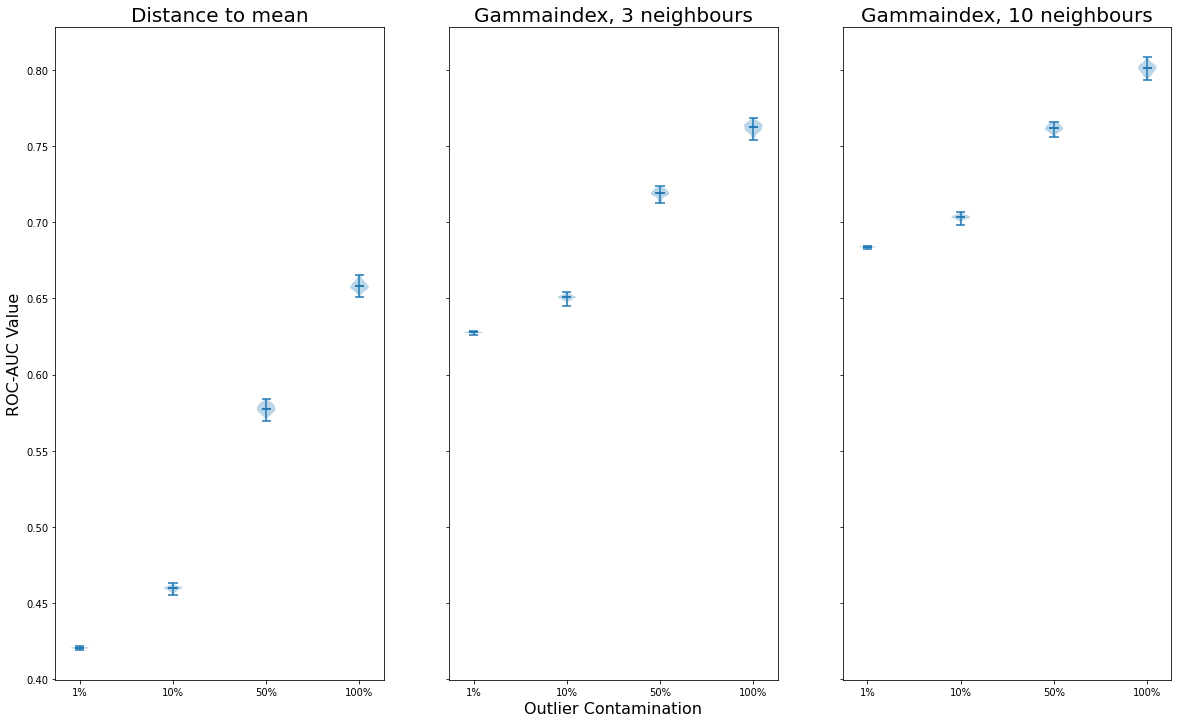

In [410]:
#Plotting Violinplot
dataG3 = [np.array(results1pct[:,0]), np.array(results10pct[:,0]), np.array(results50pct[:,0]), np.array(results100pct[:,0])]
dataG10 = [np.array(results1pct[:,1]), np.array(results10pct[:,1]), np.array(results50pct[:,1]), np.array(results100pct[:,1])]
dataM = [np.array(results1pct[:,2]), np.array(results10pct[:,2]), np.array(results50pct[:,2]), np.array(results100pct[:,2])]
fs = 20
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), sharey = True, sharex = True)

axes[0].violinplot(dataM, widths=0.2,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
axes[0].set_title('Distance to mean', fontsize=fs)
axes[0].set_ylabel('ROC-AUC Value', fontsize=16)
axes[1].violinplot(dataG3, widths=0.2,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
axes[1].set_title('Gammaindex, 3 neighbours', fontsize=fs)
axes[1].set_xlabel('Outlier Contamination', fontsize=16)
axes[2].violinplot(dataG10, widths=0.2,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
axes[2].set_title('Gammaindex, 10 neighbours', fontsize=fs)


cats = ['1%','10%','50%','100%']
plt.xticks([1,2,3,4], cats)

plt.show()

In [518]:
#Obtaining example data
exampleRun, exampleLabels, exampleOutliers, exScores, exTimes, exTimeAvg = testXtimes(1, 75, returnOutliers=True, returnScores=True)


Starting cycle 1...
Finished in 12.6 seconds


In [724]:
#score reshaping - distance measure scores are getting mapped to the range of 0-1 to ensure comparability
bananaScores = exScores.T[np.where(exampleLabels<2)]
outScores = exScores.T[np.where(exampleLabels==2)]
bScore = np.array([bananaScores[:,2],bananaScores[:,0],bananaScores[:,1]])
oScore = np.array([outScores[:,2],outScores[:,0],outScores[:,1]])
scores = (bScore, oScore)
maxScore = max(np.max(scores[0]),np.max(scores[1]))
scores[0][0] = (scores[0][0])/maxScore
scores[1][0] = (scores[1][0])/maxScore

<function matplotlib.pyplot.show(*args, **kw)>

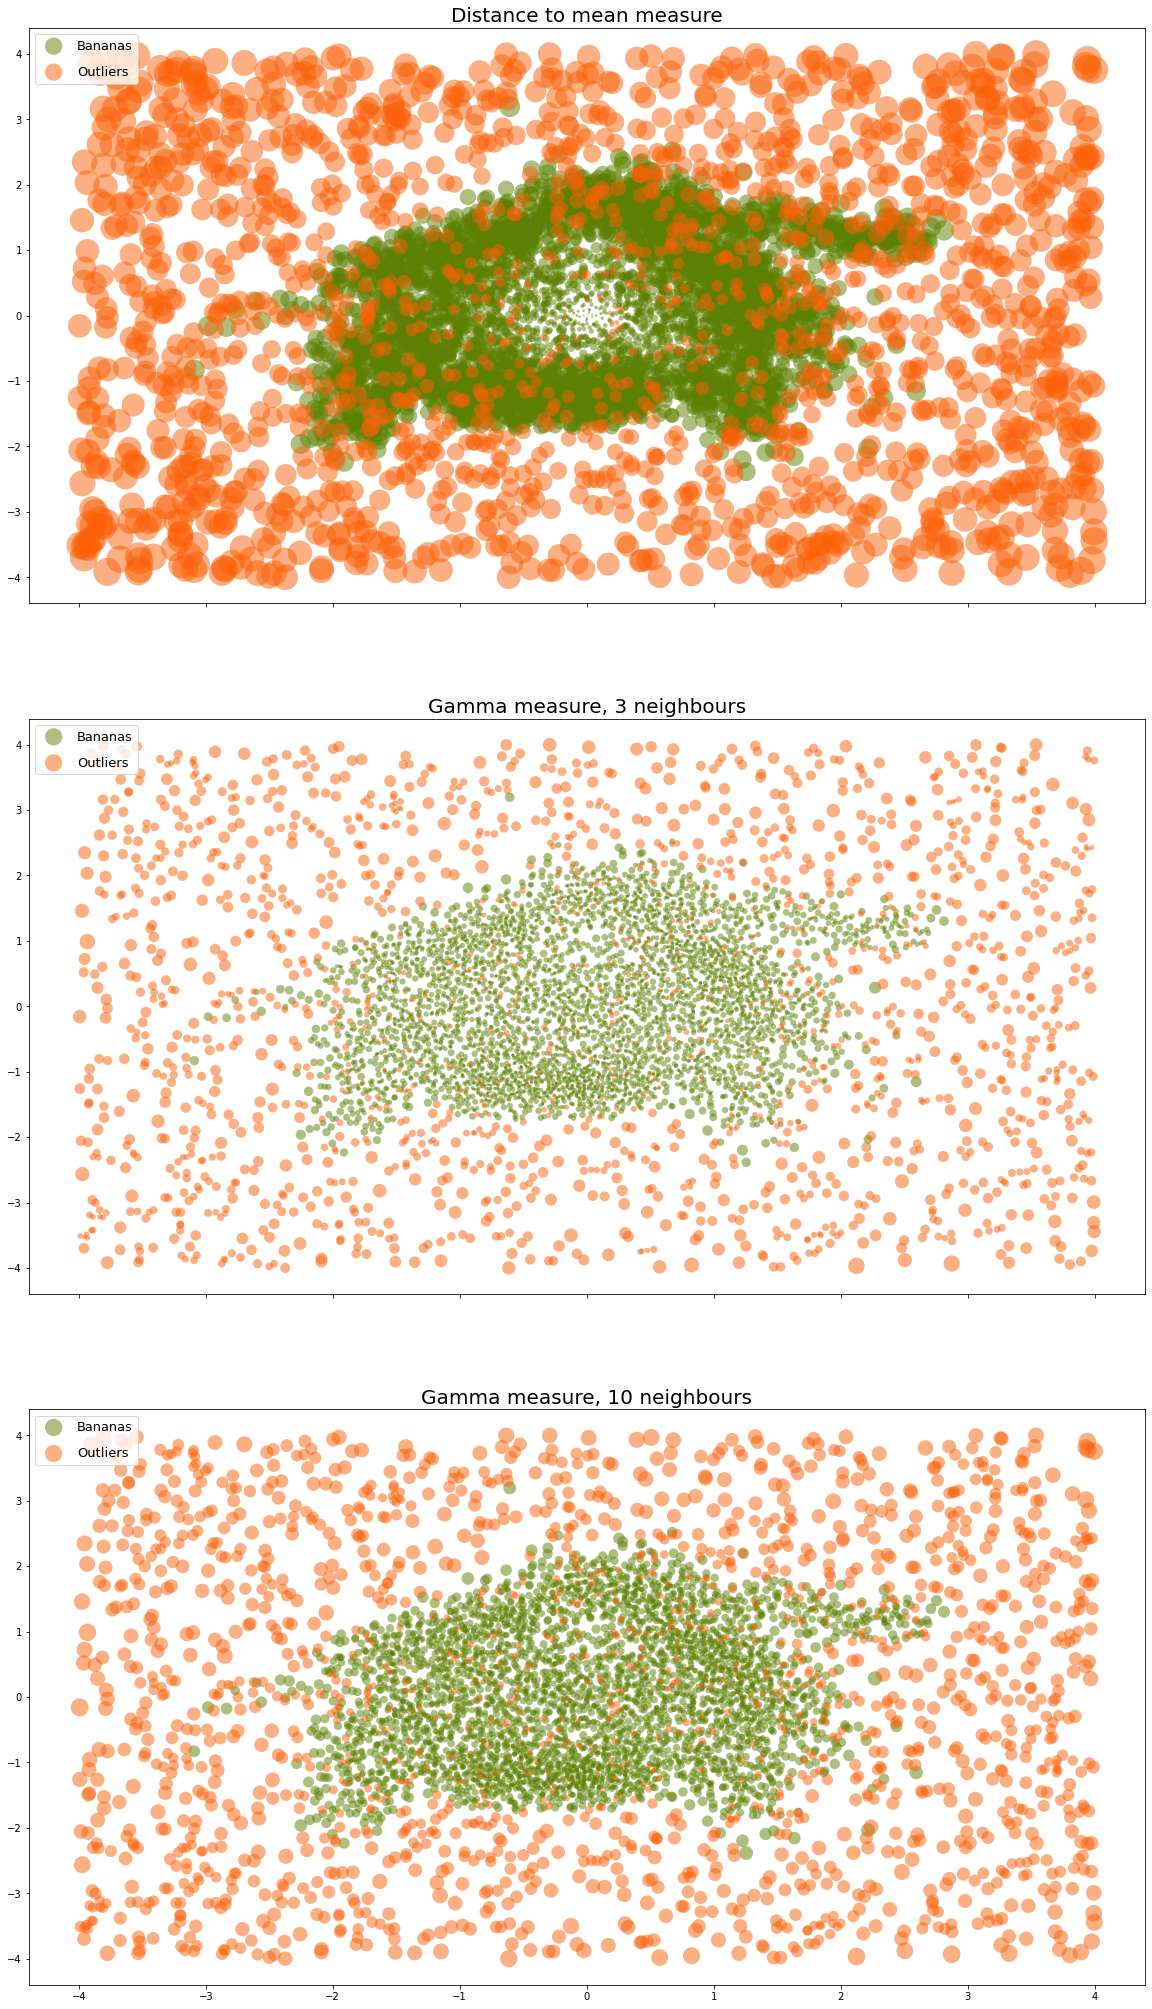

In [745]:
#Plotting
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 36), sharey = True, sharex = True)
for i in range(0,3):
    data = (bananas_data.T, exampleOutliers.T)
    x, y = data
    colors = ('#5C8001','#FB6107')
    groups = ('Bananas', 'Outliers')
    scores = (bScore, oScore)
    for data, color, group, score in zip(data, colors, groups, scores):
        x = data[0]
        y = data[1]
        sc = score[i,:]
        ax[i].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=(sc**1.1)*800, label=group)
ax[0].set_title('Distance to mean measure', fontsize=20)
lgnd = ax[0].legend(loc=2, labelspacing=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [300]
lgnd.legendHandles[1]._sizes = [300]
ax[1].set_title('Gamma measure, 3 neighbours', fontsize=20)
lgnd = ax[1].legend(loc=2, labelspacing=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [300]
lgnd.legendHandles[1]._sizes = [300]
ax[2].set_title('Gamma measure, 10 neighbours', fontsize=20)
lgnd = ax[2].legend(loc=2, labelspacing=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [300]
lgnd.legendHandles[1]._sizes = [300]
plt.show